# Defining Roles

## GOAL: Classify Heroes within two roles: Core, Support - in a way that can simply be re-run on new data. 

Before we get to the good stuff, we'll have to import a lot of our tools from the python ecosystem. scikit-learn is where a lot of the standardized machine-learing and ML support algorithms live. We'll be exploring both unsupervised and supervised algorithms in this Notebook, so you'll see some clustering and classification algorithms, as well as some ensemble methods in the import list. Matplotlib, Seaborn, and Pillow all help to support the visualization that we'll do in order to make this exercise a bit more intuitive and friendly. Who wants to JUST look at numbers all day?? The remaining imports like pandas, itertools, and numpy all act as the glue in helping us manipulate our data.

In [1]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn import svm
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools as it
import seaborn as sns
import sklearn
import pandas as pd
import numpy as np

%matplotlib inline

## So we're ready to go ... right?

Well, not exactly - cosmetics are important! I very much live under the mantra that [*"Code is written for humans, and merely executed by computers"*][1]. For me, it's very important to write code that I can read, but also design visualizations with the same thought in mind. If I come back to an analysis I did six months ago, I don't want to have to remember what and why I did things.

I've written a few helper methods that help with styling and generally making things prettier. I won't go over these line by line, but they should be aptly named to give you an idea of what's going on. We'll also be using the attractive [FiveThirtyEight][2] plot styling and standardizing our text styles as well.

[1]: https://www.quora.com/How-true-is-Programs-are-meant-to-be-read-by-humans-and-only-incidentally-for-computers-to-execute
[2]: http://fivethirtyeight.com/

In [2]:
def set_plt_bgcolor(
    fig: mpl.figure.Figure,
    ax: mpl.axes.Axes,
    *,
    color: str='xkcd:light grey'
):
    """
    Sets the figure, ax, and spine colors to <color>.
    """
    fig.set_facecolor(color)
    
    if isinstance(ax, np.ndarray):
        axes = it.chain(*ax)
    else:
        axes = [ax]
    
    for ax in axes:
        ax.set_facecolor(color)

        for spine in ax.spines.values():
            spine.set_edgecolor(color)


def plot_hero_icons(
    ax: mpl.axes.Axes,
    data: pd.DataFrame,
    *,
    x: str,
    y: str,
    img_scaling: float=1.0,
    predicate=None
):
    """
    Plot Hero icons over datapoints.
    
    This makes our resulting graphic a bit prettier. :)
    """
    if predicate is not None:
        data = data[predicate]
    
    for _, row in data.iterrows():
        X = row[x]
        Y = row[y]
        icon = i = Image.open(f'../data/icons/{row.uri}.png')
        icon_scaled = icon.resize([int(i.width * img_scaling), int(i.height * img_scaling)])
        imgbox = OffsetImage(icon_scaled)
        ab = AnnotationBbox(imgbox, [X, Y], frameon=False)
        ax.add_artist(ab)


def plot_decision_boundary(
    X: np.array,
    *,
    clf: sklearn.base.BaseEstimator,
    ax: mpl.axes.Axes,
    **kwargs
):
    """
    Plot the decision boundary for a given classifier.
    
    Adapted from:
        http://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html
    """
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.2),
                         np.arange(y_min, y_max, 0.2))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, **kwargs)


FONTSTYLE_KWARGS = {
    'weight': 'bold',
    'color': 'xkcd:almost black',
    'alpha': 0.85
}


mpl.style.use('fivethirtyeight')

---

---

## Data Pull

For many different purposes, I've created a library called DotAPI (for now, unreleased & unpublished). It's a little library that has wrappers around the [many][1]. [fantastic][2]. [statistics][3]. [websites][4]. that were created to support the dota community. Valve's game of DotA is very data-rich and both these sites' and dotapi's purpose is to provide a way to interact with and aggregate the information that's made available. For our purposes, I've extracted the dataset we'll be working with and saved it in this repo as `data/raw_data.csv`.

The SQL query that was used to pull the data from my store is below. I have over 50,000 matches in my database as it stands when I released this notebook - that's a LOT of data when you consider that for every match, there's a O2M relationship with players, and for every player there's another O2M relationship for their purchases as well. You can see in the first join, we are essentially filtering our entire dataset by only taking a sample of matches from a specific game version (aka "patch"). From there, we'll join all the player-level data from `players`, and some select in-game purchasing behavior from `purchases`. The item IDs you see are from Valve's classifications of Support and Attack/Luxury items that are used to identify `team_` and `greedy_` respectively.

```sql
SELECT  h.display_name
       ,h.primary_attr
       ,h.uri
       ,p.*
       ,b.obs_purchased
       ,b.sen_purchased
       ,b.team_items_purchased
       ,b.greedy_items_purchased
  FROM dotapi.players p
  JOIN dotapi.patch_7_15_sample s ON s.match_id = p.match_id
  JOIN (
  
        SELECT  p.match_id
               ,p.hero_id
               ,SUM(p.item_id = 42) AS 'obs_purchased'
               ,SUM(p.item_id = 43) AS 'sen_purchased'
               ,SUM(p.item_id IN (30, 45, 79, 81, 90, 92, 102, 112, 164, 185, 187,
                                  188, 210, 229, 231, 242, 254, 267)
                ) AS 'team_items_purchased'
               ,SUM(p.item_id IN (1, 65, 96, 98, 104, 108, 116, 121, 133, 135,
                                  137, 139, 141, 143, 145, 147, 149, 151, 152,
                                  156, 158, 160, 168, 172, 174, 176, 190, 201,
                                  202, 203, 204, 208, 225, 235, 247, 249, 250,
                                  252, 259, 260)
                ) AS 'greedy_items_purchased'
          FROM dotapi.purchases p
      GROUP BY p.match_id, p.hero_id
  
  ) b ON b.match_id = p.match_id AND b.hero_id = p.hero_id
  JOIN dotapi.heroes h ON h.id = p.hero_id
```

### Let's read all this in from the CSV and see what we're working with.

[1]: [https://stratz.com/]
[2]: [https://www.opendota.com/]
[3]: [https://www.dotabuff.com/]
[4]: [https://dota2.gamepedia.com/Dota_2_Wiki]

In [3]:
raw_df = pd.read_csv('../data/raw_data.csv')
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28960 entries, 0 to 28959
Data columns (total 43 columns):
display_name              28960 non-null object
primary_attr              28960 non-null object
uri                       28960 non-null object
match_id                  28960 non-null int64
hero_id                   28960 non-null int64
slot                      28960 non-null int64
steam_id                  28960 non-null int64
abandoned                 28960 non-null int64
is_radiant                28960 non-null int64
tower_dmg                 28960 non-null int64
healing                   28960 non-null int64
hero_dmg_dealt            28960 non-null int64
hero_dmg_taken            28960 non-null int64
time_dead                 28960 non-null int64
gold_fed                  28960 non-null int64
gold_lost                 28960 non-null int64
illu_deaths               28960 non-null int64
cheese_count              28960 non-null int64
refresher_shard_count     28960 non-null i

---

---

## Basic Data Cleaning

Because I have a large amount of [domain knowledge][1], a few things already jump out to me as useless information. Things like IDs or what team the player was assigned to don't help us understand what role the a hero would be classified as. We'll go ahead and drop the sort of data that is irrelevant to the gameplay itself - with the exception of some friendly identifiers like hero name and its primary attribute.

Additionally, it looks like some of our columns are missing a significant amount of data. Some of the APIs don't always play nicely and simply don't record data unless you're within the highest skill level in the game. There's good reason for this, given that there are 20 million+ monthly active players and that a single game replay file can hold over 50MB of JSON data, these stats providers process a LOT of data. Let's go ahead and drop anything we wouldn't be able to viably impute due to lack of data. A personal rule of thumb of mine is to simply drop the entire feature if more than 25% of the data would have to be imputed and in this case, that will get rid of all the infringing columns.

Finally, we'll consolidate our 20K+ records by grouping by our heroes and taking the mean of each group. This will effectively give us a view of the most likely way a hero has performed within the patch.

[1]: https://www.quora.com/Is-domain-knowledge-necessary-for-a-data-scientist

In [4]:
raw_df = raw_df.drop(columns=['match_id', 'hero_id', 'slot', 'steam_id', 'abandoned',
                      'is_radiant', 'apm', 'pings', 'party_size'])
raw_df = raw_df.dropna(axis=1, thresh=round(len(raw_df.index) * .75))
avg_df = raw_df.groupby(['display_name', 'uri', 'primary_attr']).mean()

data_cols = list(avg_df.columns)
identity_cols = list(avg_df.index.names)
avg_df = avg_df.reset_index()

avg_df.sample(10)

,display_name,uri,primary_attr,tower_dmg,healing,hero_dmg_dealt,hero_dmg_taken,time_dead,gold_fed,gold_lost,...,xpm,kills,deaths,assists,last_hits,denies,obs_purchased,sen_purchased,team_items_purchased,greedy_items_purchased
70,Phoenix,phoenix,str,423.590551,3696.480315,20212.645669,0.0,337.732283,3609.212598,-1617.330709,...,470.299213,5.889764,8.000000,17.307087,95.220472,3.755906,4.464567,4.110236,1.629921,1.196850
76,Riki,riki,agi,581.665354,43.007874,23343.053150,0.0,379.889764,3957.940945,-1719.265748,...,530.966535,9.753937,8.033465,14.015748,77.204724,4.003937,1.688976,1.883858,0.429134,2.377953
16,Chen,chen,int,2130.360000,4485.920000,9596.800000,0.0,382.200000,3933.400000,-1739.680000,...,378.280000,4.560000,9.560000,13.920000,66.600000,2.200000,5.000000,3.440000,3.320000,0.960000
32,Enchantress,enchantress,int,1882.184211,1779.552632,19640.881579,0.0,337.565789,3704.144737,-1634.921053,...,481.065789,8.447368,7.315789,10.210526,100.710526,7.486842,1.539474,1.342105,1.447368,1.144737
45,Lich,lich,int,665.356808,631.647887,18052.276995,0.0,394.859155,3740.676056,-1602.868545,...,466.887324,6.018779,8.671362,17.234742,65.605634,3.934272,8.154930,6.455399,2.563380,0.779343
3,Anti-Mage,antimage,agi,4412.655172,66.479624,19936.426332,0.0,335.611285,3849.278997,-1921.557994,...,614.583072,8.310345,6.517241,7.855799,320.783699,12.341693,0.169279,0.184953,0.141066,3.708464
17,Clinkz,clinkz,agi,5287.020408,11.510204,23033.783673,0.0,421.816327,4714.636735,-2112.824490,...,565.608163,11.273469,7.938776,8.787755,151.530612,8.028571,0.453061,0.608163,0.489796,3.106122
108,Warlock,warlock,int,1597.585034,5374.972789,17857.925170,0.0,327.095238,3219.741497,-1351.863946,...,437.170068,4.931973,7.972789,16.142857,76.061224,3.979592,8.224490,6.455782,2.170068,0.802721
40,Juggernaut,juggernaut,agi,4283.495146,5943.374757,23551.240777,0.0,356.221359,4194.613592,-2006.990291,...,614.184466,9.425243,6.982524,10.324272,271.520388,13.532039,0.120388,0.217476,0.069903,3.258252
26,Dragon Knight,dragon_knight,str,4080.429134,7.236220,22049.074803,0.0,348.696850,3906.468504,-1781.984252,...,568.429134,7.704724,6.767717,12.125984,193.149606,9.708661,0.181102,0.385827,0.641732,2.736220


### Cool! So far, we've pared down our 43 columns to a solid 24.

From looking at the some of the rows of data, it appears that we have a column (`hero_dmg_taken`) with a bunch of zeroes. It seems a bit odd for so many records to have zero interactions between heroes - it's probably bad data.

We can detect this sort of thing and remove columns that don't meet a standard amount of variance. This is where our first `sklearn` algorithm comes in! I would call this sort of activity a pre-processing step, but it can be seen as [feature selection][1] as well. We are methodically eliminating features that would cause noise in our pipeline. We'll get more into feature selection in a moment as it's very important to model accuracy.

For our purposes, let's set a variance threshold of 3%.

[1]: https://medium.com/ai%C2%B3-theory-practice-business/three-effective-feature-selection-strategies-e1f86f331fb1

In [5]:
def filter_low_variance(
    df: pd.DataFrame,
    *,
    threshold: float=0.00,
) -> pd.DataFrame:
    """
    Remove features from <df> that don't
    have <threshold>% of variance.
    """
    selector = VarianceThreshold(threshold)
    scaled_df = StandardScaler().fit_transform(df)
    selector.fit(scaled_df)
    return df.iloc[:, selector.get_support()]

before = avg_df[data_cols].columns
df = filter_low_variance(avg_df[data_cols], threshold=0.03)
after = df.columns

print(f'before: {before.size} columns\n\n{before}')
print('\n\n---\n')
print(f'after: {after.size} columns\n\n{after}')

data_cols = list(df.columns)
df = avg_df[[*identity_cols, *data_cols]].copy()

before: 21 columns

Index(['tower_dmg', 'healing', 'hero_dmg_dealt', 'hero_dmg_taken', 'time_dead',
       'gold_fed', 'gold_lost', 'illu_deaths', 'cheese_count',
       'refresher_shard_count', 'gpm', 'xpm', 'kills', 'deaths', 'assists',
       'last_hits', 'denies', 'obs_purchased', 'sen_purchased',
       'team_items_purchased', 'greedy_items_purchased'],
      dtype='object')


---

after: 20 columns

Index(['tower_dmg', 'healing', 'hero_dmg_dealt', 'time_dead', 'gold_fed',
       'gold_lost', 'illu_deaths', 'cheese_count', 'refresher_shard_count',
       'gpm', 'xpm', 'kills', 'deaths', 'assists', 'last_hits', 'denies',
       'obs_purchased', 'sen_purchased', 'team_items_purchased',
       'greedy_items_purchased'],
      dtype='object')


---

---

## Understanding your Data

Before we move on to feature selection, let's get a bit better of an intuition on the two roles. We'll take an examplary hero from each role and learn a little bit about them. This way, we'll have a sort of baseline for when we go about trying to classify other heroes from the game.

<table class="main" align="center">
    <tr class="images">
        <td align="center"><img src="../data/crystal_maiden.png" alt="crystal maiden" /></td>
        <td align="center"><img src="../data/spectre.png" alt="spectre" /></td>
    </tr>
</table>

### __Support__: Crystal Maiden
![Crystal Maiden.png][support]

Quick synopsis: Skills that allow her to control or limit the movements of her enemies, as well as benefit the team's ability to be aggressive during the early-to-mid portion of the game. Highly fragile.

*Renowned as a well-balanced hard support, Crystal Maiden possesses strong nukes and disables that allow her to apply strong slows to enemies. Her first ability (Crystal Nova) is a powerful area-of-effect nuke that slows both attack and movement speeds of enemies within an area for several seconds, while her second ability (Frostbite) encases an enemy in a block of ice for several seconds, immobilizing them and dealing moderate damage per second. Her third ability (Arcane Aura) is passive will regenerate mana for herself and her allies, greatly boosting their ability to cast spells in the early game. Her global mana aura, strong disabling and nuking prowess, simple spell layout, and almost complete lack of item dependence make Crystal Maiden a reliable support caster that can be a strong asset to any team. With protection from her team and appropriate item selection, she can be the only support any team needs.*


### __Core__: Spectre
![Spectre.png][core]

Quick synopsis: Greatly relies on gold and experience in order to become effective, but once acquired, is one of the strongest heroes on the map. Has no abilities that directly help the team, however has a kit that directly allows the hero to become a large threat once it is "ready" to fight.

*Adept at dealing pure damage to lone targets, Spectre is powerful both offensively and defensively. Her second ability (Desolate) allows her to inflict high pure damage to enemy heroes when she catches them alone. Her third ability (Dispersion) reduces and reflects all damage, whether by attacks or spells, to an area around her. Dispersion gives her great durability, especially when equipped with items that provide health, armor, and damage block. Finally, her fourth ability (Haunt) creates a malevolent spectral illusion to all enemy heroes on the map. Haunt lets Spectre wreak havoc in clashes and ganks, while her allies take advantage of the confusion. Spectre can instantly teleport to her illusions to take its form, letting her hound her victims from anywhere on the map. Her kit allows her to play the role of the team's hard carry by applying an immense amount of pressure in late game team fights. More specifically, the damage reflection from Dispersion makes it disadvantageous for teams to focus her. Her abilities have a complex nature, and newer players should generally not play Spectre as she is extremely farm and level dependent.*

You'll see that these traits are reflected in many of the stats as well. On average, Spectre does almost **four times** as much damage as Crystal Maiden does. Crystal Maiden also spends more time dead and overall has less resources devoted to her (GPM & XPM, or **G**old / e**X**perience **P**er **M**inute). Additionally, Crystal Maiden purchases far more team items on average than Spectre does.

[support]: ../data/icons/crystal_maiden.png
[core]: ../data/icons/spectre.png

In [6]:
CORE = 'Spectre'
SUPPORT = 'Crystal Maiden'

mask = df.display_name.isin([CORE, SUPPORT])

df[mask][['display_name', *data_cols]]\
        .set_index('display_name')\
        .applymap(lambda v: round(v, 4) if abs(v) < 1 else round(v, 2))\
        .rename_axis([''])

,tower_dmg,healing,hero_dmg_dealt,time_dead,gold_fed,gold_lost,illu_deaths,cheese_count,refresher_shard_count,gpm,xpm,kills,deaths,assists,last_hits,denies,obs_purchased,sen_purchased,team_items_purchased,greedy_items_purchased
,,,,,,,,,,,,,,,,,,,,
Crystal Maiden,457.83,98.67,15157.92,426.06,4025.93,-1753.25,0.1309,0.0223,0.0223,341.55,436.71,5.09,9.93,16.57,64.63,2.19,9.4300,7.1600,2.480,1.28
Spectre,2233.03,44.29,39867.80,358.42,4112.86,-1920.65,0.0367,0.0336,0.0336,515.87,606.52,10.61,7.27,18.22,245.69,11.63,0.1315,0.2569,0.367,2.19


### To get an even better sense of our dataset, let's look at some important aggregations across the features.

Right off the bat, we can confirm a few things in the above descriptions of Cystal Maiden and Spectre. Certain key statistics like GPM, XPM, Hero Damage Dealt all match the magnitude of direction of what's described in each profile. What's missing from this view is how the distributions for-each hero are laid out. It's nice that this data looks to confirm our initial assumptions, but we need to look deeper. There doesn't look to be much variation in a few of the features like Deaths-to-Illusions and Cheese and Refresher Shard count. These certainly don't mean anything to you as a layperson (hint: they're likely irrelevant to our problem as well), but are they meaningful to the problem? Let's find out.

In [7]:
def quartile(p=1.0) -> callable:
    """
    Calculates quartile as <p> percentile.
    """
    f = lambda df: df.quantile(p)
    f.__name__ = f'Q{int(p / .25)}'
    return f

df[data_cols].agg(['min', quartile(.25), 'median', quartile(.75), 'max', 'mean', 'std'])\
             .applymap(lambda v: round(v, 4) if abs(v) < 1 else round(v, 2))

,tower_dmg,healing,hero_dmg_dealt,time_dead,gold_fed,gold_lost,illu_deaths,cheese_count,refresher_shard_count,gpm,xpm,kills,deaths,assists,last_hits,denies,obs_purchased,sen_purchased,team_items_purchased,greedy_items_purchased
min,153.48,3.02,7762.63,286.67,2948.68,-2863.84,0.0367,0.0000,0.0000,284.60,378.28,2.98,6.26,6.43,32.46,0.6169,0.1042,0.1042,0.0699,0.0952
Q1,629.61,42.05,15648.52,356.11,3760.96,-2119.67,0.1307,0.0102,0.0102,357.20,455.74,5.28,7.58,11.19,82.75,3.7900,0.4228,0.4276,0.4743,0.9917
median,1684.69,123.80,20018.52,387.23,4102.78,-1868.77,0.1538,0.0262,0.0262,426.58,508.60,7.53,8.37,13.61,152.81,5.7200,1.3900,1.0800,1.0800,1.7900
Q3,3068.86,625.15,24665.61,420.08,4613.90,-1667.11,0.2094,0.0458,0.0458,484.08,569.13,9.46,9.17,15.91,200.59,9.5400,3.8600,2.9700,2.1500,2.5900
max,6457.33,9787.35,44247.22,561.35,6189.38,-1254.07,0.4400,0.3212,0.3212,677.25,790.21,12.71,11.56,22.73,326.64,24.8100,10.6100,9.1800,3.4600,4.3700
mean,2025.19,924.23,20592.17,389.37,4184.44,-1908.53,0.1708,0.0314,0.0314,421.41,513.73,7.46,8.42,13.69,149.66,7.0900,2.6400,2.1700,1.3200,1.8700
std,1531.68,1827.67,6592.11,46.40,625.93,329.75,0.0625,0.0365,0.0365,78.67,72.63,2.53,1.07,3.06,71.45,4.5500,3.0300,2.4000,0.9474,1.0400


---

---

## Feature Selection

In looking more closely at our data, we should be able to selectively identify areas that could cause noise in our models. We've already filtered out low-variance features, so let's keep going down that route and attempt to find other features of our data that have observances that are "too similar" to each other.

The code in the cell directly below draws a distribution plot for each feature. What we'll end up with is approxiamately (depending on how variant our initial features were) 20 [KDE plots][1]. I really like the KDE plot because it's a simple visualization that gives a strong intuition into the distribution of data within a feature. The natural alternative would be a histogram, however the number of bins can greatly influences one's understanding of their data. A great short explanation on the differences can be found [here][2].\*

There are some general themes in the game of DotA, as it has its roots in a story-based game. Simply put, the three main classes **AGI**lity, **INT**elligence, and **STR**ength tend to gravitate towards a certain focus. Agility heroes are typically your Cores, dealing high damage but have low health pools themselves. Intelligence heroes are more often than not in the Support role, and are usually not very durable either. In contrast the Strength class is a bit of flex role, boasting high durability, low damage output, and oftentimes have abilities to disrupt or start fights. For these reasons, and to make our graphs a bit more interesting, I chose to draw each class separately within the plots.

It can then be understood that if all three classes have a similar distribution, high kurtosis, **and** that distribution is highly skewed, that the feature is unlikely to help us in determining a given hero's role within the game. In other words, if a feature has a sharp peak and significant amount of skew, then many of the datapoints are centralized around a single value. It might pass our previous variance test, but the difference between the data is still likely to negatively influence our model. This will also give us a reproducible way to selectively remove features from out dataset - remembering the ultimate goal.

---

\*I made the choice not to include any precision on the axes both for simplicity, but also because **KD E**stimation plots are inherently going to be slightly misleading. While our left-most plotline is indeed `0.0`, it would be impossible to have negative purchases, yet the bottom row of plots clearly show a small amount of the distribution below `0.0`. Besides, what we are most interested in here is the shape of these graphs.

[1]: https://www.youtube.com/watch?v=yN7GBdkN9EU
[2]: http://www.mvstat.net/tduong/research/seminars/seminar-2001-05/

       └──> kurtosis: 7.201071837821191, skew: 2.670239172816125

       └──> kurtosis: 2.946246198437694, skew: 1.1624027336916387

       └──> kurtosis: 35.28172326606253, skew: 4.8483873155979635

       └──> kurtosis: 35.28172326606253, skew: 4.8483873155979635



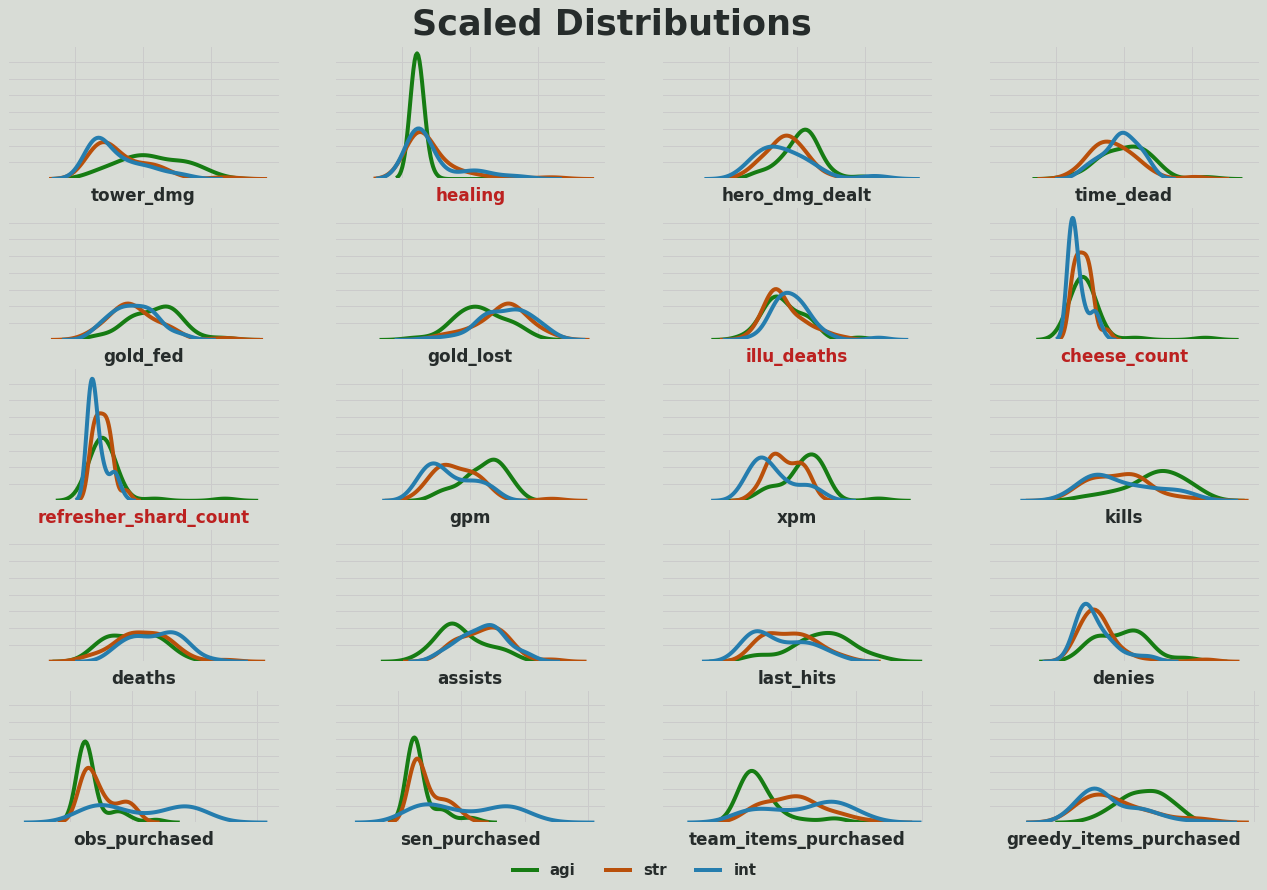

In [8]:
fig, axes = plt.subplots(figsize=(20, 20 / 1.5), ncols=4, nrows=5)

color_map = {
    'agi': '#167C13',
    'str': '#B9500B',
    'int': '#257DAE'
}

# PREP DATA
# - leave our underlying data undisturbed
# - scale our values so they can be graphed side-by-side
X_df = df.copy()
X_df[data_cols] = MinMaxScaler((0, 10)).fit_transform(X_df[data_cols])
to_drop = []

# GRAPH
for col, ax in zip(data_cols, list(it.chain(*axes))):
    font = FONTSTYLE_KWARGS.copy()

    # separate the three classes
    for hero_class, color in color_map.items():
        temp = X_df[X_df.primary_attr == hero_class][col]
        sns.kdeplot(temp, color=color, legend=False, ax=ax)
    
    # isolate features that don't fall within the parameters
    if abs(X_df[col].kurt()) > 2.58:
        print(f'WARNING: column "{col}" has values outside the norm')
        print(f'       └──> kurtosis: {X_df[col].kurt()}, skew: {X_df[col].skew()}\n')
        to_drop.append(col)
        font.update({'color': '#b70000'})

    ax.set_xlabel(col, **font)
    ax.set_xticklabels([])
    ax.set_xticks(np.arange(-6., 15., 5.))
    ax.set_yticks(np.arange(0., .9, .1))
    ax.set_yticklabels([])

# LEGEND
handles, labels = ax.get_legend_handles_labels()
L = fig.legend(handles, color_map.keys(), ncol=3, frameon=False,
               loc='lower center', facecolor='#D8DCD6')
plt.setp(L.texts, fontsize=15, **FONTSTYLE_KWARGS)

# TITLE
fig.suptitle('Scaled Distributions', fontsize=35, y=0.92, **FONTSTYLE_KWARGS)
set_plt_bgcolor(fig, axes)

# SELECTION
data_cols = list(set(data_cols) - set(to_drop))

### KDE Results

Just as we initially thought, the three columns that looked a bit "off" certainly are! What I also found surprising about this exercise is that we revealed Healing to be a similarly poorly distributed feature. You would think that healing might be a primary function of a hero classified as "Support", much like you might assume this is main role of a battlefield medic. It's very clearly not an ability that is well represented in the Agility class, and apparently not sufficient enough for our classification exercise either.

Some other interesting things to note here:
- Agility class has more heroes purchasing items for themselves
- Intelligence class having the most heroes purchasing items for the benefit of the team
- two main resource-KPIs (GPM, XPM) show a split between the classes similar to who their "story" is devised.
    - Support, INT
    - Flex, STR
    - Core, AGI

---

Great! So now that we have gotten rid of some of the noise in our dataset, what else can we do to eliminate features? What about eliminating redundnacy? We looked at similarly within a feature, but what about two features that are similar to each other? This idea can be expressed as correlation across features, and visualized with heatmap of the correlation matrix. We'll keep the correlation as-is (both positive and negative correlations will be expressed), however when we look to do selection it will be important to eliminate features that exceed a given threshold.

Pulling on more domain knowledge here to give you some examples of expected positive and negative correlations within the game data. 

### Postive Correlation

The GPM metric is a function of how much gold you've gathered over the coure of the game, divided by the total game duration. There are many ways to gain gold, but the main method of doing so is to kill minions on the map. You earn a small variable amount of gold for each kind of enemy minion you kill, or land the "last hit" on. It can be assumed that there is a high positive correlation between these two features, as the number of `last_hits` go up, so should your `gpm`.

### Negative Correlation

If we take second to think about the support role, one that we know should be purchasing items to benefit the team, we might also assume that this role does not deal a large amount of damage to the enemy heroes. Items that benefit the team typically help to mitigate damage, or heal allies - and thus a fair amount of the role's resources are not going towards the goal of damaging the eney. As the number of `team_items_purchased` goes up, we should naturally assume that the amount of `hero_dmg_dealt` will go down.

       └──> correlation: {'sen_purchased': 0.9928028200599875}



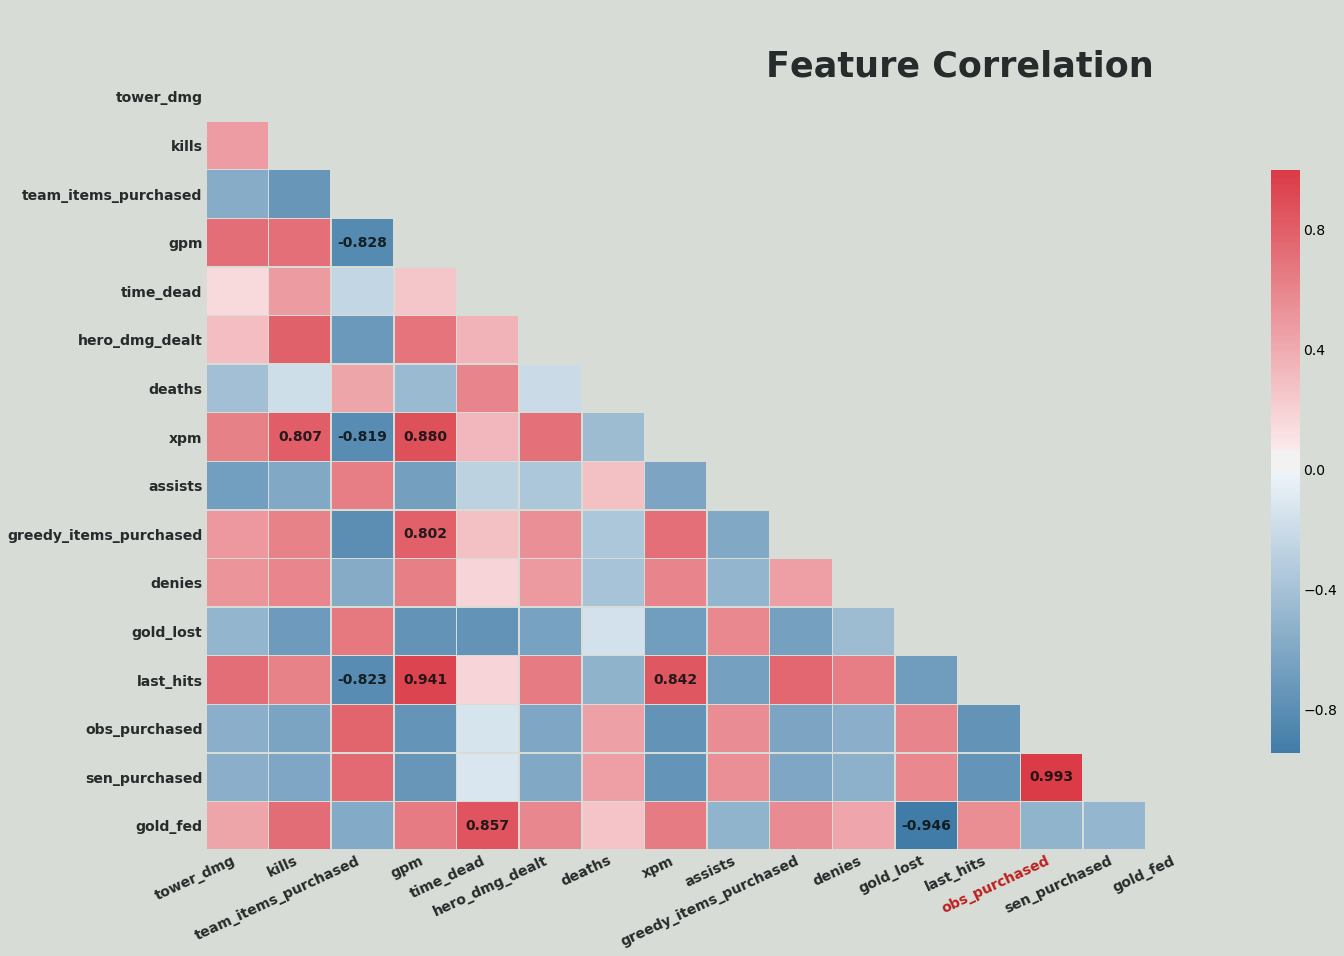

In [9]:
fig, ax = plt.subplots(figsize=(20, 20 / 1.5))

cmap = sns.diverging_palette(240, 10, as_cmap=True)

# PREP DATA
corr = df[data_cols].corr()
corr_abs = corr.abs()
to_drop = []

# - identify labels for points above 85% abs(correlation)
labels_mask = np.zeros_like(corr, dtype=np.bool)
labels_mask[np.tril_indices_from(labels_mask)] = True
labels = corr[(labels_mask) & ((corr >= .80) | (corr <= -.80)) & (corr != 1.)]

# GRAPH
# - create transparent mask on upper-triangle (data is mirrored across the diagonal)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corr, cmap=cmap, linewidths=.5, linecolor='xkcd:light grey',
                 annot_kws={'ha': 'center', 'va': 'center', 'color': FONTSTYLE_KWARGS.get('color')},
                 cbar_kws={'shrink': .75}, mask=mask, ax=ax)

# isolate features with high correlation
for x, column in enumerate(corr.columns):
    series = corr[column].drop(set([column, *to_drop]))
    correlated = (series >= 0.80) | (series <= -0.80)
    high_corr = (series >= 0.95) | (series <= -0.95)

    # plot labels
    if any(correlated):
        for k, v in series[correlated].to_dict().items():
            y = corr.columns.get_loc(k)
            if labels.iat[y, x] == v:
                ax.text(x + .5, y + .5, f'{v:.3f}', ha='center', va='center', **FONTSTYLE_KWARGS)
    
    # isolate features that don't fall within the parameters
    if any(high_corr) and column not in to_drop:
        highly_correlated = series[high_corr].to_dict()
        print(f'WARNING: column "{column}" is highly correlated with: {", ".join(highly_correlated.keys())}')
        print(f'       └──> correlation: {highly_correlated}\n')
        to_drop.append(column)

# beautify
ax.set_yticklabels(ax.get_yticklabels(), **FONTSTYLE_KWARGS)
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right', **FONTSTYLE_KWARGS)

# colorize the eliminated features
for xtick in ax.get_xticklabels():
    if xtick.get_text() in to_drop:
        xtick.set_color(color='#b70000')

ax.annotate('Feature Correlation', xy=(.57, .92), xycoords='figure fraction', fontsize=35, **FONTSTYLE_KWARGS)
set_plt_bgcolor(fig, ax)

# SELECTION
data_cols = list(set(data_cols) - set(to_drop))

### Correlation Results

We can observe an almost-perfect correlation between the number of observer wards and sentry wards purchased. These are items that give different types of vision on the battlefield, and are typically bought alongside each other by the hero(es) in the support role. They are cheap and are purchased often, so it makes sense that they are incredibly highly correlated. I won't go into some of the other correlations seen as it takes a fair amount of game understanding. For now, we are happy with the result of this selection method!

---

### With that, we have our base dataset!

We can finally separate off the features from our hero names and hero classes. Here's a sample of what the end (beginning?) result looks like.

In [10]:
X = df[data_cols].copy()
df = df[[*identity_cols, *X.columns]].copy()

df[['display_name', *X.columns]]\
  .set_index('display_name')\
  .sample(10)\
  .applymap(lambda v: round(v, 4) if abs(v) < 1 else round(v, 2))\
  .rename_axis([''])

,tower_dmg,kills,team_items_purchased,gpm,time_dead,hero_dmg_dealt,deaths,xpm,assists,greedy_items_purchased,denies,gold_lost,last_hits,sen_purchased,gold_fed
,,,,,,,,,,,,,,,
Storm Spirit,1545.82,11.55,0.1529,507.64,355.45,26971.22,7.98,626.02,12.24,3.1200,8.27,-2135.62,217.44,0.2325,4631.89
Undying,680.51,6.10,1.9900,347.59,391.81,13967.06,9.22,449.03,19.20,0.4312,5.34,-1797.75,84.46,2.0000,3972.83
Warlock,1597.59,4.93,2.1700,336.95,327.10,17857.93,7.97,437.17,16.14,0.8027,3.98,-1351.86,76.06,6.4600,3219.74
Lone Druid,4791.75,4.23,0.7917,438.94,286.67,14594.29,6.54,427.58,8.60,2.1500,6.17,-1588.06,221.21,0.1042,3189.33
Elder Titan,519.44,4.25,1.7800,328.02,301.71,17021.32,7.82,445.91,15.95,0.4824,3.08,-1293.58,76.85,3.3400,3087.35
Doom,946.73,7.23,1.7200,451.03,389.52,20462.43,8.50,512.29,15.37,1.7800,5.21,-2059.87,128.53,0.5238,4422.44
Venomancer,1474.22,6.29,1.3600,435.38,455.98,28347.78,10.04,468.01,16.66,1.9200,4.45,-2351.88,144.69,2.6200,4864.99
Viper,2776.50,9.49,0.8542,446.59,418.60,25836.18,8.28,553.08,12.68,1.3300,12.90,-2065.61,166.73,0.6319,4556.53
Ursa,1900.69,11.14,1.0700,448.80,432.79,24935.35,8.79,552.35,9.67,2.9600,5.69,-2177.12,152.85,0.2061,4882.30


---

---

## Feature Extraction & Visualizing High Dimensionality
Now that we have a nice base for our data, we can go about playing around with different models and try solving our core-support problem. Since we don't already have labels on our data for each role, we'll have to choose a unsupervised algorithm to work with. If we think about our data in terms of a graph, then each feature is an additional axis to consider when plotting the "point" that is our hero. It can be reasoned that Spectre, as a point of data is very "far" away from the datapoint that represents Crystal Maiden. We don't necessarily have a "high dimensionality" problem, but there are enough features here to make graphing the dataset quite impossible. If this sense of compressing multiple dimensions down to just a few is confusing to you, that's because it's conceptually very complex however [Carl Sagan explains it very well][1]!

Essentially what we will be attempting to do is find two center points within our data, and classify the rest of the heroes that are nearest to one of the two points. First off though, lets trying using a couple of techniques to give us a sense of how our data looks as whole. This is just as much an exploratory exercise as it is prep. for building our final model.

---

### Domain Knowledge: GPM v XPM
From the very beginning, we've been saying "cores are devoted more resources than supports". We have two main indicators of how many resources were gathered over the course of a game, gold- and experience-per-minute. Let's use these two as a baseline for our understanding. We COULD assume these are indicative of what it means to be part of each role, except as you learn more about the game and how it's played, certain Supports have abilities that granted them bonus experience or gold. This would skew their placement within a classification system that only considers these two features. It's possible these are the most representative features, however!

---

### Principal Component Analysis (PCA)
Simply put, PCA uses the correlation between dimensions to provide a given number of variables that preserves the maximum amount of variation about of how the original data is distributed. The intuition behind PCA is similar to what we did earlier when we filtered out the lowly-distributed features of Healing and Illusion Deaths. Since the algorithm seeks to maximize the amount of variance to explain the dataset, it's important to standardize your data, just like we did when visualizing the distributions.

If you're interested in a fun beginner understanding of PCA, I recommend starting with this [video][2].
<br/>
If you're interested in the maths behind the algorithm, I recommend starting with [this page][3].

---

### t-Schochastic Neighbor Embedding (TSNE)
Simply put, TSNE calculates sort of a "similarity score" for each point relative to all other points in the dataset, and then seeks to minimize the distance between all neighboring points. TSNE embeds the distribution of a feature into a lower dimensional space and then compares the divergence between the high-dim and low-dim spaces.

If you're interested in a better, simple explanation of TSNE, [this article][4] does pretty well.
<br/>
If you're interested in the maths behind the algorithm and getting a better understanding of how it works, I recommend starting with [this page][5].

[1]: https://www.youtube.com/watch?v=N0WjV6MmCyM
[2]: https://www.youtube.com/watch?v=HMOI_lkzW08
[3]: https://www.math.hmc.edu/calculus/tutorials/eigenstuff/
[4]: https://www.displayr.com/using-t-sne-to-visualize-data-before-prediction
[5]: https://distill.pub/2016/misread-tsne/

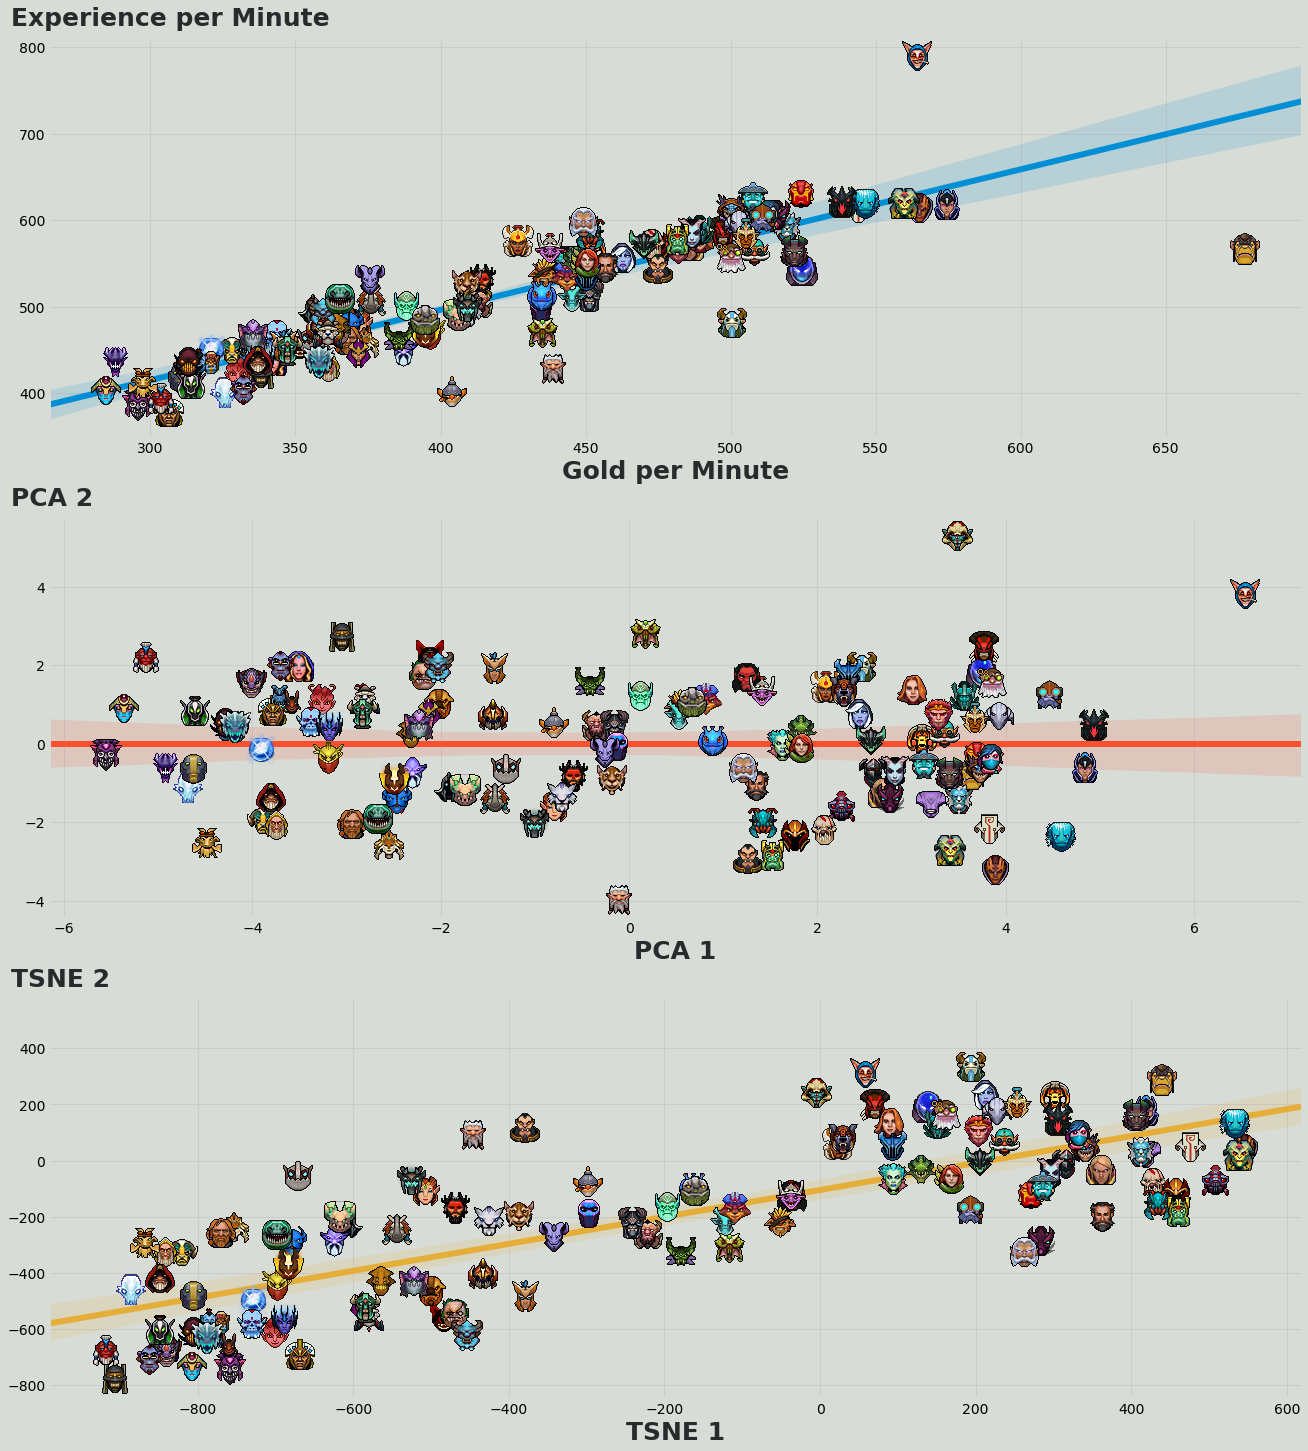

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(20, (20 / 1.5) + 10), nrows=3)

# -----
# Baseline
# -----

temp = df[['uri', 'gpm', 'xpm']].copy()

# graph & beautify
sns.regplot(x='gpm', y='xpm', data=temp, marker='.', fit_reg=True, ax=ax1)
ax1.set_xlabel('Gold per Minute', fontsize=25, **FONTSTYLE_KWARGS)
ax1.set_ylabel('')
ax1.annotate('Experience per Minute', xy=(-0.03, 1.03), xycoords='axes fraction', size=25, **FONTSTYLE_KWARGS)
plot_hero_icons(ax1, temp, x='gpm', y='xpm')
set_plt_bgcolor(fig, ax1)

# -----
# Principal Component Analysis
# -----

temp = df[['display_name', 'uri']].copy()
X_standardized = StandardScaler().fit_transform(X)

# train, fit the model, tranform our X
X_pca = PCA(n_components=2).fit_transform(X_standardized)
temp['pca_1'] = X_pca[:, 0]
temp['pca_2'] = X_pca[:, 1]

# graph & beautify
sns.regplot(x='pca_1', y='pca_2', data=temp, marker='.', fit_reg=True, ax=ax2)
ax2.set_xlabel('PCA 1', fontsize=25, **FONTSTYLE_KWARGS)
ax2.set_ylabel('')
ax2.annotate('PCA 2', xy=(-0.03, 1.03), xycoords='axes fraction', size=25, **FONTSTYLE_KWARGS)
plot_hero_icons(ax2, temp, x='pca_1', y='pca_2')
set_plt_bgcolor(fig, ax2)

# -----
# t-Schochastic Neighbor Embedding
# -----

# train, fit the model, tranform our X
X_tsne = TSNE(n_components=2, n_iter_without_progress=5000).fit_transform(X_standardized)
# NOTE:
#
# For some reason that I do not understand, MPL or Seaborn were not very happy with axes that were some order
# of magnitudes smaller than the others, so I simply scaled the TSNE vectors by 100. MPL definitely supports
# axes with varied scales as evidence ax1 and ax2 .. so I'm not really sure what's up there. :|
temp['tsne_1'] = X_tsne[:, 0] * 100
temp['tsne_2'] = X_tsne[:, 1] * 100

# graph & beautify
sns.regplot(x='tsne_1', y='tsne_2', data=temp, marker='.', fit_reg=True, ax=ax3)
ax3.set_xlabel('TSNE 1', fontsize=25, **FONTSTYLE_KWARGS)
ax3.set_ylabel('')
ax3.annotate('TSNE 2', xy=(-0.03, 1.03), xycoords='axes fraction', size=25, **FONTSTYLE_KWARGS)
plot_hero_icons(ax3, temp, x='tsne_1', y='tsne_2')
set_plt_bgcolor(fig, ax3)

### Linearity of Reduced Dimensions

The results of each are pretty exciting here! Not only do both reduction algorithms show some linearity, TSNE actually strikingly resembles the original metrics of our baseline graph, but on the full higher dimensional view of our data. There doesn't appear to be much, if any, clusters within the relationship of PCA features, but there's certainly a clear distinction between Spectre (`2.9, -1.9`) and Crystal Maiden (`-3.5, 2.0`). TSNE does appear to reveal some slight clustering however! It's certainly possible to distinguish the cluster at the lower left from the one at the top right of the curve.

---

---

## Clustering & Labeling

Speaking of clusters ... why don't we trying running a clustering *algorithm* on the output of our TSNE data? Clustering is a type of unsupervised learning method that takes unlabeled data and attempts to group similar points together. The algorithm we'll start off with is what's known as k-means clustering. This algorithm seeks to partition our data into `k` number of clusters, and observations as labeled as within the cluster that they are closest to in terms of their distance. Once all the datapoints are initially classified, new centroids are chosen from the created clusters, and the process repeats until we meet convergence - or when two iterations have the same output.

`sklearn` gives us a handy model that implements k-means nicely. There are many options for tuning this model, including just initializing it bare and then feeding your data into it. The naked setting will do all the dirty work of randomizing your inital cluster centroids, computing the distances, and finally spitting out classes for the `k` specified. Since we already have an idea from above of where to "start" with algorithm, we'll pass in the centroids as Crystal Maiden and Spectre and see how the algorithm deals from there.

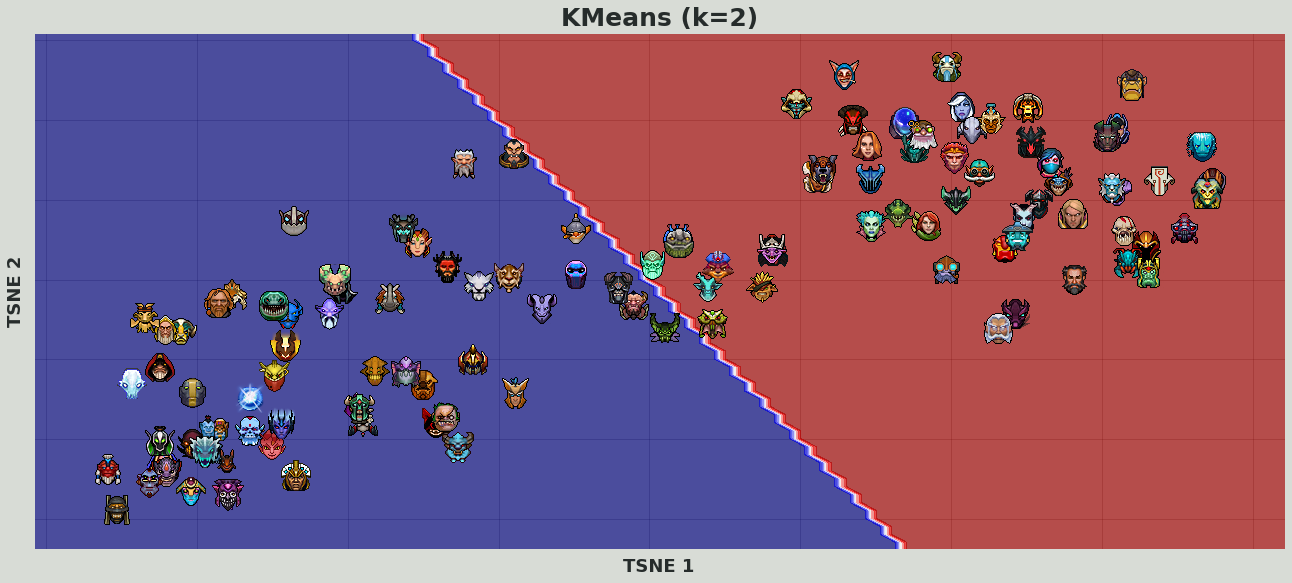

In [12]:
# data prep
temp = df[['display_name', 'uri']].copy()
temp['tsne_1'] = X_tsne[:, 0]
temp['tsne_2'] = X_tsne[:, 1]

# set our k-value
k = 2

# grab initial points for our clusters
centroids = temp[temp.display_name.isin([SUPPORT, CORE])]

# train & fit the model
model = KMeans(n_clusters=k, n_init=1, init=centroids[['tsne_1', 'tsne_2']].values)
model.fit(temp[['tsne_1', 'tsne_2']])

# graph & beautify
fig, ax = plt.subplots(figsize=(20, (20 / 1.5 / 1.5)))
sns.regplot(x='tsne_1', y='tsne_2', data=temp, marker='.', fit_reg=False, ax=ax)
ax.set_title(f'KMeans (k={k})', fontsize=25, **FONTSTYLE_KWARGS)
ax.set_xlabel('TSNE 1', fontsize=18, **FONTSTYLE_KWARGS)
ax.set_xticklabels([])
ax.set_ylabel('TSNE 2', fontsize=18, **FONTSTYLE_KWARGS)
ax.set_yticklabels([])
ax.grid(color='k', alpha=.2)

plot_hero_icons(ax, temp, x='tsne_1', y='tsne_2')
plot_decision_boundary(X_tsne, clf=model, ax=ax, alpha=.65, cmap=plt.cm.seismic)
set_plt_bgcolor(fig, ax)

### KMeans Result, k=2

This is great! I plotted & shaded the decision boundary so we can get a better sense of how the algorithm converged. The bottom left is our Support class, while the top portion is the Core. The algorithm gets this pretty accurate, but it doesn't help us understand how "certain" a given hero is within a specific role. Heroes near the dividing line could certainly be considered in a Flex role where they don't really fall within either category, but at the same time could lean towards either role in a pinch.

We could initalize the algorithm with `k=3`, but in looking at graph above, I am willing to bet that this would result in the same outcome: more points are being "misclassified" or don't really fit either role. Instead, we'll take a step back and go a bit more in-depth on the concept of roles in DotA.

While it's true that there are two main classifications for these roles, the team is made up of five heroes. Certain heroes might need an early amount of a gold and experience in order to transition into thier true role, while others might be deprioritized entirely in terms of resources. This idea is very well expressed in the higher tiers of play, and we call it "Farm Priority". Players are assigned an implicit number from 1 - 5 in terms of their priority of gathering resources on the map. Heroes in the "1 position" have the highest priority, and you are expected to allow them to the safest and most bountiful areas of the map and the opposite is true for the 5 position. Very typically, this means positions 1 - 3 will be cores, while 4 and 5 will be the supports.

Instead of `k=3`, let's go along with this concept of farm priority and seek 5 clusters instead. From here, we'll be able to say that the cluster Crystal Maiden is in is decidedly a "support" cluster, while the opposite is true for Spectre.

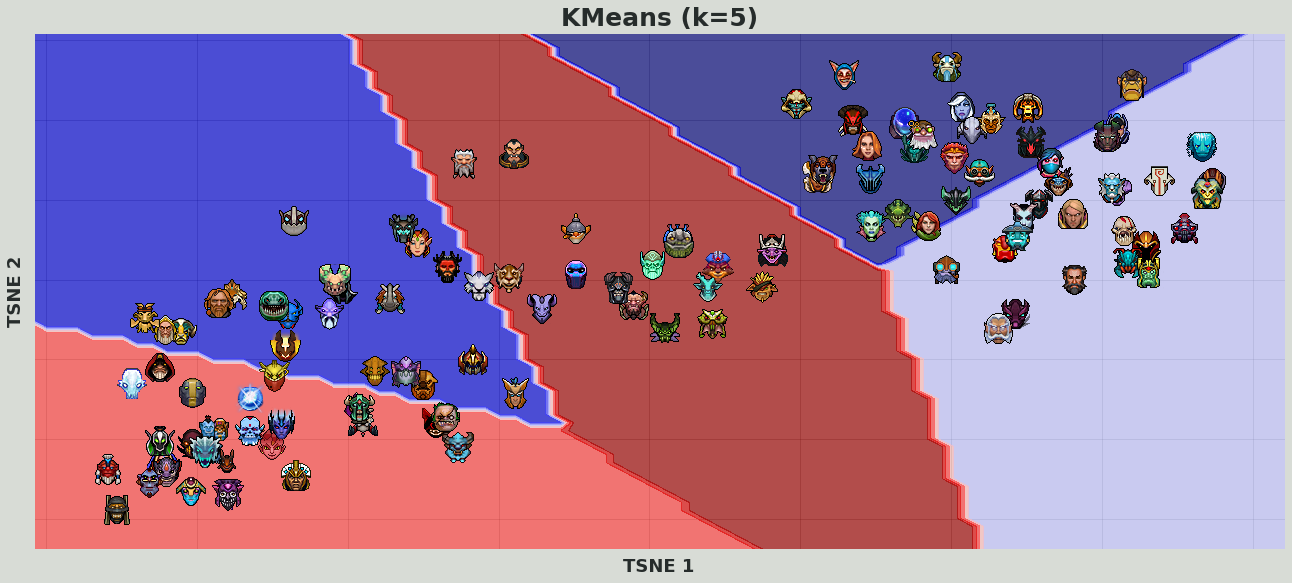

In [13]:
# train & fit the model
k = 5
model = KMeans(n_clusters=k)
model.fit(temp[['tsne_1', 'tsne_2']])

# graph & beautify
fig, ax = plt.subplots(figsize=(20, (20 / 1.5 / 1.5)))
sns.regplot(x='tsne_1', y='tsne_2', data=temp, marker='.', fit_reg=False, ax=ax)
ax.set_title(f'KMeans (k={k})', fontsize=25, **FONTSTYLE_KWARGS)
ax.set_xlabel('TSNE 1', fontsize=18, **FONTSTYLE_KWARGS)
ax.set_xticklabels([])
ax.set_ylabel('TSNE 2', fontsize=18, **FONTSTYLE_KWARGS)
ax.set_yticklabels([])
ax.grid(color='k', alpha=.2)

plot_hero_icons(ax, temp, x='tsne_1', y='tsne_2')
plot_decision_boundary(X_tsne, clf=model, ax=ax, alpha=.65, cmap=plt.cm.seismic)
set_plt_bgcolor(fig, ax)

### KMeans Result, k=5

Now you can clearly see a sort of delineation between the farm priorities within this graph. It appears that there's roughly an equal amount of heroes in each grouping. This makes a bit more "sense" to me and my level of understanding of the game, but it still isn't up to snuff with what I want. There are heroes in the complementary top cluster that I would most definitely consider "cores", as well as supports in the cluster just above Crystal Maiden's.

This does give a GREAT baseline and segue into another method of grouping like-datapoints: classification algorithms! We mentioned that we can decidedly say that Crystal Maiden is a support and Spectre is a core and that heroes which fall into these clusters are also soundly labeled. What if we partitioned these heroes off from our original dataset and used them as input for a supervised learning algorithm? Classification algorithms belong to the supervised family of methods where you have *some* labeled data, and you want to slot unlabeled data into those known observances.

## Classification

We'll split off our labeled data and assign the variable `y` to the labels themselves, and the data to `X`. We'll then feed this data into a few different classification models. A natural by-product of the various methods we'll try is that the model will compute a probability associate with each classification. Every hero likely has tendencies towards both roles, and this will give us a way to assess the strength of the classification.

Remember from our graph above that the kmeans algorithm is essentially just clustering similarly-located datapoints, and that the TSNE features that we engineered are but a representation of our total dataset. This understanding extends to our new classification problem.

In [14]:
# SETUP
temp['role'] = model.labels_
s = temp.set_index('display_name').at['Crystal Maiden', 'role']
c = temp.set_index('display_name').at['Spectre', 'role']
df['role'] = temp.role.replace({s: 'support', c: 'core'}).replace(range(6), value=np.nan)

iden_cols = [*identity_cols, 'role']
data_cols = df.columns.difference(iden_cols)
role_mask = pd.notnull(df.role)

X = df[role_mask][data_cols].copy()
y = df[role_mask]['role'].copy()

unlabeled_X = df[~role_mask][data_cols].copy()
unlabeled_identities = df[~role_mask][identity_cols].copy()

### k-Nearest Neighbors (KNN)

The KNN algorithm is a very simple, but effective algorithm when dealing with distances. The algorithm will classify a given observation based on the `k` nearest points to it. The majority number of points that are closest to our observation is the winning class, and thus the observation is estimated to be of that class. `sklearn` defines this algorithm for us with a default value of `k=5` which we will take and run with. The only parameter I am tuning on this algorithm is how each neighbor is weighted. By default all neighbors are weighted equally, however since we know our data has a linearity to it, we can instruct the algorithm to weight closer neighbors more highly.

In [15]:
knn_clf = KNeighborsClassifier(weights='distance')
knn_clf.fit(X, y)

labels = knn_clf.predict(unlabeled_X)
proba = knn_clf.predict_proba(unlabeled_X)
knn_mean_proba = proba.max(axis=1).mean()

print(f'k-Nearest Neighbors')
print(f'└──> mean probability of label: {knn_mean_proba * 100:.2f}%\n')

unlabeled_identities.merge(pd.DataFrame(labels, columns=['role'], index=unlabeled_identities.index),
                           left_index=True, right_index=True)\
                    .merge(pd.DataFrame(proba, columns=['p_core', 'p_supp'], index=unlabeled_identities.index),
                           left_index=True, right_index=True)\
                    .head(10)

k-Nearest Neighbors
└──> mean probability of label: 95.10%



,display_name,uri,primary_attr,role,p_core,p_supp
0,Abaddon,abaddon,str,support,0.000000,1.000000
1,Alchemist,alchemist,str,core,0.879050,0.120950
4,Arc Warden,arc_warden,agi,core,1.000000,0.000000
5,Axe,axe,str,core,1.000000,0.000000
8,Beastmaster,beastmaster,str,support,0.404805,0.595195
9,Bloodseeker,bloodseeker,agi,core,1.000000,0.000000
11,Brewmaster,brewmaster,str,support,0.186691,0.813309
12,Bristleback,bristleback,str,core,1.000000,0.000000
14,Centaur Warrunner,centaur,str,core,0.678655,0.321345
17,Clinkz,clinkz,agi,core,1.000000,0.000000


Looking at the first ten unlabeled heroes, this algorithm appears to get a lot of the classifications correct, but there are a few that I would not personally consider "correct" observations. Additionally, the probabilities on certain heroes make little sense to me. I am hesitant when an algorithm give a perfect probabilty to a specific class and this is happening very often in our sample of 10. This is reflected in the fact that the mean probability is so high as well. We know that a portion of these datapoints should be closer to a 50/50 probability split, which would naturally pull the mean down. There's certainly some good things happening here, but let's try another method.

---

### Support Vector Machine (SVC)

The goal of the support vector machine family of algorithms is to draw a hyperplane at the edge of each class. Think back to our `k=2` kmeans exercise and imagine the decision boundary being the hyperplane in this case - it is a very similar understanding. We'll turn back to `sklearn` yet again for this algorithm, but this time we'll need to wrap it in a `CalibratedClassifier` in order to gain access to our probabilities. By default, the SVM defines a loss function and uses that to calculate a "score", but that doesn't help us to determine the likelihood that a hero is of a given class. That's where the `CalibratedClassifier` comes in - `sklearn`'s got our back and does all the hard work for us.

In [16]:
svc_clf = CalibratedClassifierCV(svm.LinearSVC())
svc_clf.fit(X, y)

labels = svc_clf.predict(unlabeled_X)
proba  = svc_clf.predict_proba(unlabeled_X)
svc_mean_proba = proba.max(axis=1).mean()

print(f'Calibrated LinearSVC')
print(f'└──> mean probability of label: {svc_mean_proba * 100:.2f}%\n')

unlabeled_identities.merge(pd.DataFrame(labels, columns=['role'], index=unlabeled_identities.index),
                           left_index=True, right_index=True)\
                    .merge(pd.DataFrame(proba, columns=['p_core', 'p_supp'], index=unlabeled_identities.index),
                           left_index=True, right_index=True)\
                    .head(10)

Calibrated LinearSVC
└──> mean probability of label: 70.54%



,display_name,uri,primary_attr,role,p_core,p_supp
0,Abaddon,abaddon,str,support,0.403584,0.596416
1,Alchemist,alchemist,str,core,0.514514,0.485486
4,Arc Warden,arc_warden,agi,core,0.549575,0.450425
5,Axe,axe,str,support,0.373373,0.626627
8,Beastmaster,beastmaster,str,core,0.584076,0.415924
9,Bloodseeker,bloodseeker,agi,core,0.544185,0.455815
11,Brewmaster,brewmaster,str,support,0.472999,0.527001
12,Bristleback,bristleback,str,core,0.789417,0.210583
14,Centaur Warrunner,centaur,str,core,0.548947,0.451053
17,Clinkz,clinkz,agi,core,0.929627,0.070373


Right off the bat, you can see this algorithm has given us different results from the last one. The mean probability is also a lot lower, and possibly more in line with our expectations. My knowledge of the game immediately raises of a red flag with the classification of Axe though - this hero is NOT a support, and I have the hero leaning more towards Core than the Support role. This might be due to how the SVM algorthimically determines the class for a given observation. [This article][1] explains it incredibly well, but essentially the points outside of the hyperplane's margin do not affect help with classification - they're ignored (skip to Cell 8 for explanation). So it's likely this phenomenon is having a significant impact on the accuracy of our classification here. While SVM algorithm definitely is getting some observations with strong classifications (Arc Warden, Bristleback), I'm not sure this is going to be our winner either. Let's keep trying!

---

### Random Forests (RF)

Finally, we'll look at an ensemble model. This a term that is used to describe a collection of models that work together to result in a classification. The combination of learning models increases classification accuracy. Random Forests specifically works as a large collection of de-correlated decision trees. The algorithm takes a subset of our classified data and creates a decision tree from the subset. Since the same algorithm is applies across various subsegments, the resulting effect helps to decrease variance in the resulting prediction - the term for this is called "bagging". Each estimator generates labels independently and results are then averaged across all. Yet again, `sklearn` has this algorithm implemented and we will simply use the default number of estimators or decision trees here.

[1]: https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html

In [17]:
rf_clf = RandomForestClassifier(n_estimators=10)
rf_clf.fit(X, y)

labels = rf_clf.predict(unlabeled_X)
proba  = rf_clf.predict_proba(unlabeled_X)
rf_mean_proba = proba.max(axis=1).mean()

print(f'RandomForestClassifier')
print(f'└──> mean probability of label: {rf_mean_proba * 100:.2f}%\n')

unlabeled_identities.merge(pd.DataFrame(labels, columns=['role'], index=unlabeled_identities.index),
                           left_index=True, right_index=True)\
                    .merge(pd.DataFrame(proba, columns=['p_core', 'p_supp'], index=unlabeled_identities.index),
                           left_index=True, right_index=True)\
                    .head(10)

RandomForestClassifier
└──> mean probability of label: 78.57%



,display_name,uri,primary_attr,role,p_core,p_supp
0,Abaddon,abaddon,str,support,0.3,0.7
1,Alchemist,alchemist,str,core,0.8,0.2
4,Arc Warden,arc_warden,agi,core,0.9,0.1
5,Axe,axe,str,core,0.7,0.3
8,Beastmaster,beastmaster,str,support,0.2,0.8
9,Bloodseeker,bloodseeker,agi,core,0.9,0.1
11,Brewmaster,brewmaster,str,core,0.9,0.1
12,Bristleback,bristleback,str,core,0.6,0.4
14,Centaur Warrunner,centaur,str,core,0.6,0.4
17,Clinkz,clinkz,agi,core,1.0,0.0


The RF appears to be a bit of a middle ground between the first two classifiers we looked at. The probabilities across these observations are a lot more in line with what I would expect, but even this one classifies certain heroes incorrectly (Centaur Warunner). No algorithm is perfect, but I think we can do better.

### Let's take a play from RF's book.

All three classifiers have slight inconsistencies, but all three classifiers have strong points to them as well. What happens if we take a majority-vote? This is another ensembling technique called "stacking", where we use the outcomes from different classification models to ultimately improve the performance of predicting classes. I'm sure you know that `sklearn` has already thought of this and implemented a clean API for us to use ... and you be correct!

We'll use the `VotingClassifier` to help us achieve model stacking. This is a majority-vote method by default, but since we have a good idea of the "strength" of our predictions, we're going to weight each classifier by the mean probabilities we observed earlier.

In [18]:
# Whoops, sklearn forgot to merge a bugfix!
# without ignoring warnings, VotingClassifier(voting='soft') will raise DeprecationWarning
#
# https://github.com/scikit-learn/scikit-learn/issues/10449
#
import warnings
warnings.filterwarnings('ignore')
#
# //

e = [('knn', knn_clf), ('svc', svc_clf), ('rfc',  rf_clf)]
w = [knn_mean_proba, svc_mean_proba, rf_mean_proba]

clf = VotingClassifier(estimators=e, voting='soft', weights=w)
clf.fit(X, y)

labels = clf.predict(unlabeled_X)
proba  = clf.predict_proba(unlabeled_X)

print(f'VotingClassifier')
print(f'└──> mean probability of label: {proba.max(axis=1).mean() * 100:.2f}%\n')

unlabeled_identities.merge(pd.DataFrame(labels, columns=['role'], index=unlabeled_identities.index),
                           left_index=True, right_index=True)\
                    .merge(pd.DataFrame(proba, columns=['p_core', 'p_supp'], index=unlabeled_identities.index),
                           left_index=True, right_index=True)\
                    .head(10)

VotingClassifier
└──> mean probability of label: 80.38%



,display_name,uri,primary_attr,role,p_core,p_supp
0,Abaddon,abaddon,str,support,0.148545,0.851455
1,Alchemist,alchemist,str,core,0.808699,0.191301
4,Arc Warden,arc_warden,agi,core,0.870962,0.129038
5,Axe,axe,str,core,0.819963,0.180037
8,Beastmaster,beastmaster,str,support,0.484263,0.515737
9,Bloodseeker,bloodseeker,agi,core,0.866901,0.133099
11,Brewmaster,brewmaster,str,support,0.465844,0.534156
12,Bristleback,bristleback,str,core,0.911358,0.088642
14,Centaur Warrunner,centaur,str,core,0.710662,0.289338
17,Clinkz,clinkz,agi,core,0.978541,0.021459


These results are incredibly promising from my observation. Not only is the mean probability high, but every single observation of the 10 that we can see looks to be classified correctly... but this does beg the question, what about results with a probability that are nearest to 50% on each role? What do we do with these observations? Well, we re-classify them as a Flex position! It might feel a bit like cheating, but we have to realize that DotA is a massively complex game, and that everything lives on a spectrum in this game.

---

## Putting it all together

We've come up with a very happy medium in our data prep and eventual classification results, however we still have yet to realize the full goal we initially set out to achieve: classify heroes within the two role in an automated fashion, that can be reproducible on new game version snapshots. We must write all the pieces together! We'll separate the exercise of data preparation from modeling. Data prep is required in all scneraios, but  we could certainly write another helper method that automates our feature selection process.

What'll we come out with is 3 different roles - Support, Core, and Flex. Let's run it and see what we get!

In [19]:
import warnings
warnings.filterwarnings('ignore')

def classify_roles(df: pd.DataFrame, id_cols: list) -> pd.DataFrame:
    """
    Classify a Hero within a Role.
    """
    # Feature Extraction
    X = df[df.columns.difference(id_cols)].copy()
    X_standardized = StandardScaler().fit_transform(X)
    X_tsne = TSNE(n_components=2, n_iter_without_progress=5000).fit_transform(X_standardized)
    df['tsne_1'] = X_tsne[:, 0]
    df['tsne_2'] = X_tsne[:, 1]

    # Clustering for base Roles
    model = KMeans(n_clusters=5)
    model.fit(X_tsne)
    df['role'] = model.labels_

    # replacing known roles with friendly categoricals
    # replacing unknown roles with np.nan
    s = df.set_index('display_name').at['Crystal Maiden', 'role']
    c = df.set_index('display_name').at['Spectre', 'role']
    df['role'] = df.role.replace({s: 'support', c: 'core'}).replace(range(6), value=np.nan)
    
    # Redefining values
    data_cols = df.columns.difference([*id_cols, 'role'])
    estimators = []
    weights = []
    
    # Classifying to impute missing Roles
    X_unlabeled = df[pd.isnull(df.role)][data_cols].copy()
    X_unlabeled_ids = df[pd.isnull(df.role)][id_cols].copy()
    X = df[pd.notnull(df.role)][data_cols].copy()
    y = df[pd.notnull(df.role)]['role'].copy()
    
    clf_knn = KNeighborsClassifier(weights='distance')
    clf_knn.fit(X, y)
    p = clf_knn.predict_proba(X_unlabeled)
    w = np.maximum(p[:, 0], p[:, 1]).mean()
    estimators.append(('knn', clf_knn))
    weights.append(w)
    
    clf_svc = CalibratedClassifierCV(svm.LinearSVC())
    clf_knn.fit(X, y)
    p = clf_knn.predict_proba(X_unlabeled)
    w = np.maximum(p[:, 0], p[:, 1]).mean()
    estimators.append(('scv', clf_svc))
    weights.append(w)
    
    clf_for = RandomForestClassifier(n_estimators=10)
    clf_for.fit(X, y)
    p = clf_for.predict_proba(X_unlabeled)
    w = np.maximum(p[:, 0], p[:, 1]).mean()
    estimators.append(('for', clf_for))
    weights.append(w)
    
    clf = VotingClassifier(estimators=estimators, voting='soft', weights=weights)
    clf.fit(X, y)
    labels = clf.predict(X_unlabeled)
    proba = clf.predict_proba(X_unlabeled)
    
    y_unlabeled = pd.DataFrame(np.column_stack((labels, proba)),
                               columns=['role', *list(clf.classes_)],
                               index=X_unlabeled_ids.index)
    
    def reclassify(s: pd.Series, thresh=.8) -> pd.Series:
        """
        If a hero doesn't meet the threshold
        for their role, reclassify to FLEX.
        """
        probability = s[['core', 'support']].max()
        
        if probability > thresh:
            return s.role
        else:
            return 'flex'

    mean_proba = proba.max(axis=1).mean()
    y_unlabeled['role'] = y_unlabeled.apply(reclassify, thresh=mean_proba, axis=1)
    df['role'] = pd.concat([y_unlabeled['role'], y]).sort_index()
    return df

# reset our frame to the "base"
df = df[df.columns.difference(['tsne_1', 'tsne_2', 'role'])].copy()

df = classify_roles(df, id_cols=identity_cols)
df[['display_name', 'primary_attr', 'role']].sample(10)

,display_name,primary_attr,role
94,Tidehunter,str,flex
9,Bloodseeker,agi,core
59,Nature's Prophet,int,flex
62,Nyx Assassin,agi,support
104,Vengeful Spirit,agi,support
15,Chaos Knight,str,core
7,Batrider,int,support
81,Shadow Shaman,int,support
109,Weaver,agi,core
44,Leshrac,int,flex


# And we have our classes!

In [20]:
from IPython.display import HTML, display

def chunker(iterable, size):
    for chunk in it.zip_longest(*[iter(iterable)] * size):
        yield filter(None, chunk)

for role in ['support', 'flex', 'core']:
    heroes = df[df.role == role].uri.values

    cells = [
        f"<td><img src='../data/icons/{hero}.png'></td>"
        for hero in heroes
    ]
    
    rows = [
        f"<center><tr>{''.join(bunch)}</tr></center>"
        for bunch in chunker(cells, 10)
    ]

    display(HTML(f"""
        <h2>{role.title()} Heroes: {len(heroes)}</h2>
        <table>
            {''.join(rows)}
        </table>
        <br />
        <br />
    """))

# Looking Forward

While I'm happy with the result of this Notebook, there are areas I'd still like to explore with this type of analysis.

- Fuzzy C-Means
    - Think of this basically as "K-means with an accuracy rating" (sound familiar?)

- Using the Elbow Method to determine the optimal number of Roles
    - The "elbow method" is validation of consistency within clustering designed to help and identify the appropriate number of clusters within a dataset. Instead of us assuming there are only 2-3 roles, we can use the elbow method to help us determine the optimal number of k clusters.

- Neural Net classification
    - Hey, this is another buzzword and an area I'd really like to explore. I understand the fundamentals of how they work, but would really enjoy learning through more dota data!

# Thanks for following along with me!